In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_cora import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.graph_sage import StructuralOmegaGraphSageCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/cora/04-1-structural_graphsage_dotmlp_gamma_function.log'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

In [7]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [8]:
data = prepare_adjencency(data)

## Training

In [12]:
for run in range(30):
    for n_layers_graph_sage in range(1, 4):
        omega = StructuralOmegaGraphSageCosSim(
            device,
            dataset='cora',
            in_channels=data.x.shape[1],
            n_layers_graph_sage=n_layers_graph_sage,
            run=run)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y.reshape(-1, 1),
                    data.adj_t)

## Results

### For a Layer Number

In [13]:
n_layers_graph_sage = 2

In [15]:
metrics = StructuralOmegaGraphSageCosSim.read_metrics(
    n_layers_graph_sage=n_layers_graph_sage,
    dataset='cora')
print(metrics.shape)
metrics.head()

(1530, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.542099,0.537336,0.547723,0.463048,0.497701,0.506847
1,0,100,0.207467,0.431209,0.463765,0.991485,0.766691,0.748657
2,0,200,0.147362,0.499510,0.529351,0.997967,0.726149,0.709153
3,0,300,0.114079,0.521497,0.573004,0.996689,0.713867,0.689513
4,0,400,0.087718,0.535356,0.615074,0.999730,0.728954,0.691858


### Sumarize metrics per epoch

In [16]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [17]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [18]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.541545,0.003297,0.534141,0.003285,0.546789,0.002568,0.499347,0.029675,0.535901,0.024896,0.523686,0.013922
100,0.207252,0.004131,0.429961,0.010115,0.469746,0.008681,0.991736,0.002631,0.774915,0.014970,0.743979,0.010098
200,0.143943,0.004942,0.465912,0.019512,0.518344,0.015042,0.997049,0.002026,0.749223,0.015081,0.717789,0.013056
300,0.109640,0.004103,0.516477,0.027146,0.569253,0.020622,0.997800,0.001627,0.730234,0.021603,0.704239,0.016157
400,0.086881,0.004629,0.557932,0.034778,0.619092,0.024360,0.998661,0.001320,0.724765,0.020728,0.694133,0.015410


In [19]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
100,0.207252,0.004131,0.429961,0.010115,0.469746,0.008681,0.991736,0.002631,0.774915,0.014970,0.743979,0.010098
200,0.143943,0.004942,0.465912,0.019512,0.518344,0.015042,0.997049,0.002026,0.749223,0.015081,0.717789,0.013056
300,0.109640,0.004103,0.516477,0.027146,0.569253,0.020622,0.997800,0.001627,0.730234,0.021603,0.704239,0.016157
400,0.086881,0.004629,0.557932,0.034778,0.619092,0.024360,0.998661,0.001320,0.724765,0.020728,0.694133,0.015410
500,0.070706,0.006071,0.596469,0.042750,0.668482,0.024555,0.998949,0.001334,0.724007,0.020647,0.689479,0.015137


/tmp/ipykernel_143774/651129664.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_143774/651129664.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_143774/651129664.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavio

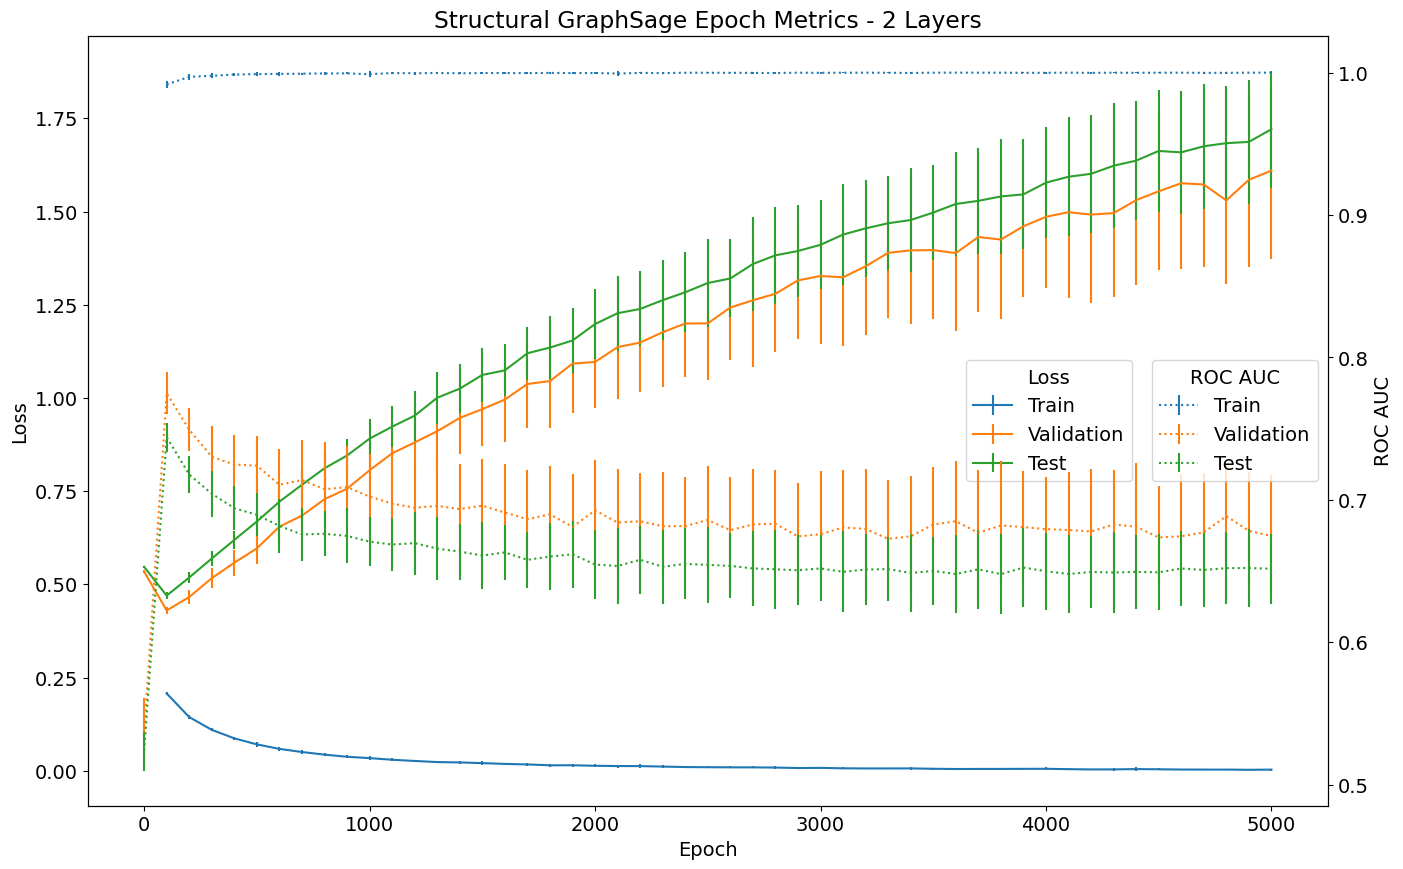

In [20]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(f'Structural GraphSage Epoch Metrics - {n_layers_graph_sage} Layers')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/cora/structural_omega_graphsage_cossim_training_metrics_{n_layers_graph_sage}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [21]:
n_layers_list = range(1, 4)

In [23]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_graph_sage in n_layers_list:
    metrics = StructuralOmegaGraphSageCosSim.read_metrics(dataset='cora', n_layers_graph_sage=n_layers_graph_sage)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_graph_sage] = auc_val
    mean_loss_val_dict[n_layers_graph_sage] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_graph_sage] = auc_val
    std_loss_val_dict[n_layers_graph_sage] = loss_val

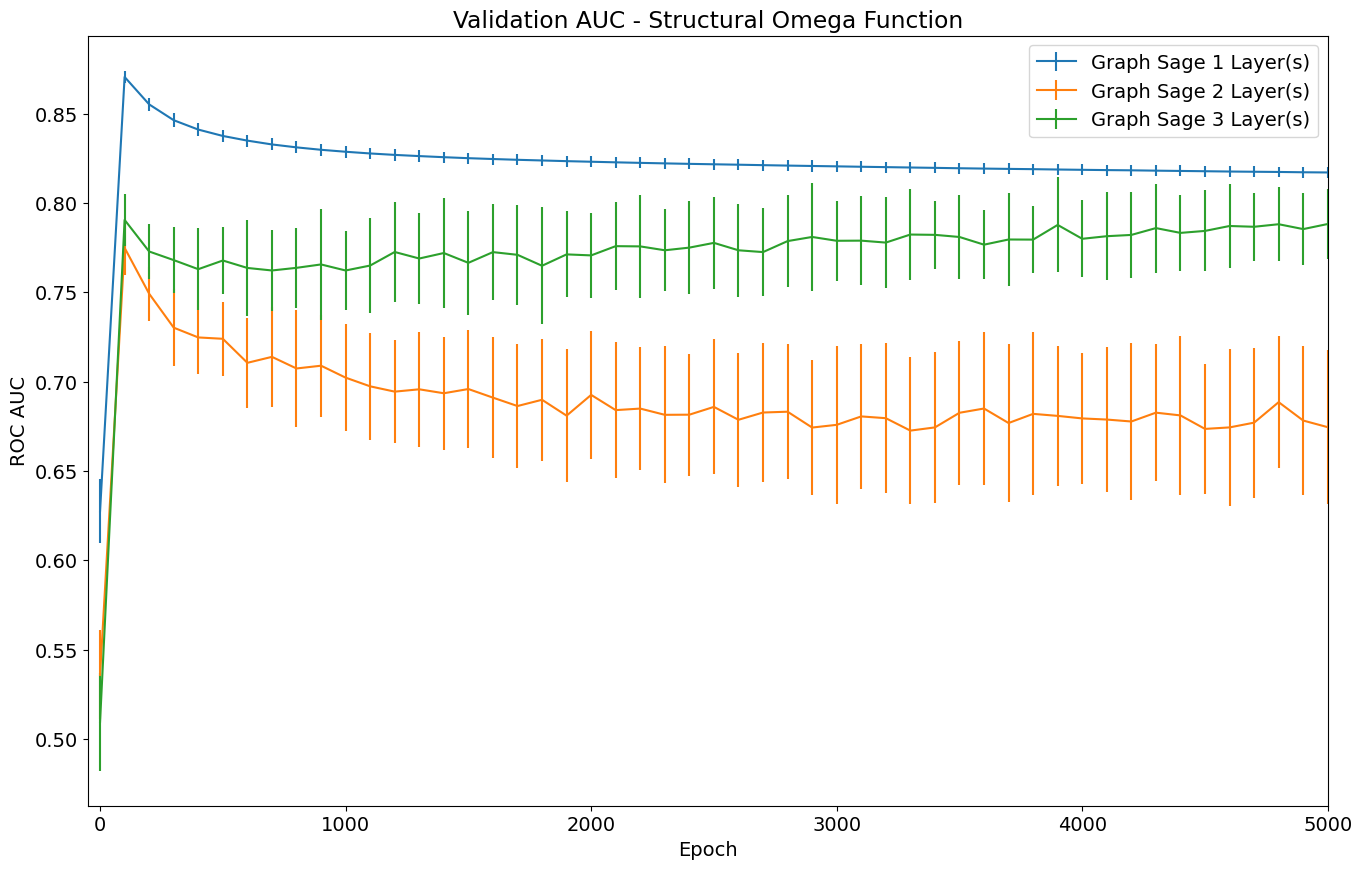

In [24]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'Graph Sage {n_layers} Layer(s)')

ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [25]:
n_layers_list = range(1, 4)

In [7]:
full_metrics = []
for n_layers_graph_sage in n_layers_list:
    metrics = StructuralOmegaGraphSageCosSim.read_metrics(
        n_layers_graph_sage=n_layers_graph_sage)
    metrics['n_layers_graph_sage'] = n_layers_graph_sage
    full_metrics.append(metrics)
full_metrics = pd.concat(full_metrics)

In [8]:
best_model_metrics = full_metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run                       4.000000
epoch                  4600.000000
loss_train                0.382392
loss_val                  0.465065
loss_test                 0.515976
auc_train                 0.889903
auc_val                   0.851588
auc_test                  0.818473
n_layers_graph_sage       3.000000
Name: 250, dtype: float64

In [9]:
best_model_metrics.to_json('models/structural_omega_grapn_sage_cossim/best_model_info.json')

### Load data

In [10]:
dataset = load_dataset()
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)
data = prepare_adjencency(data)

### Load model

In [11]:
omega = StructuralOmegaGraphSageCosSim.load_model(
    run=int(best_model_metrics['run']),
    epoch=int(best_model_metrics['epoch']),
    device=device,
    n_layers_graph_sage=int(best_model_metrics['n_layers_graph_sage']))

### Score model

In [12]:
all_edges = torch.concat([edges_train, edges_val, edges_test], dim=1)
all_edges.shape

torch.Size([2, 1166243])

In [13]:
preds = omega.forward(all_edges, data.x, data.adj_t).to('cpu').detach().numpy()
preds[:5]

array([[0.39369652],
       [0.11731733],
       [0.46927968],
       [0.12220458],
       [0.04423578]], dtype=float32)

In [15]:
theta = omega.is_same_class(all_edges, data.y).to('cpu').detach().numpy()

In [16]:
roc_auc_score(theta, preds)

0.8699908991623656

In [17]:
theta.mean()

0.655083031580897

In [18]:
preds.mean()

0.76895744

### Save output

In [19]:
cpu_edges = all_edges.to('cpu').numpy()
edges_gamma_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'gamma_pred': preds[:,0]
})
print(edges_gamma_df.shape)
edges_gamma_df.head()

(1166243, 3)


,source,target,gamma_pred
0,104447,13091,0.393697
1,15858,47283,0.117317
2,107156,69161,0.469280
3,107156,136440,0.122205
4,107156,107366,0.044236


In [21]:
os.makedirs('data/structural_omega_graph_sage_cossim', exist_ok=True)
edges_gamma_df.to_csv('data/structural_omega_graph_sage_cossim/04-1_gamma_scored_edges.csv', index=False)

Text(0.5, 1.0, 'Omega distribution over all edges')

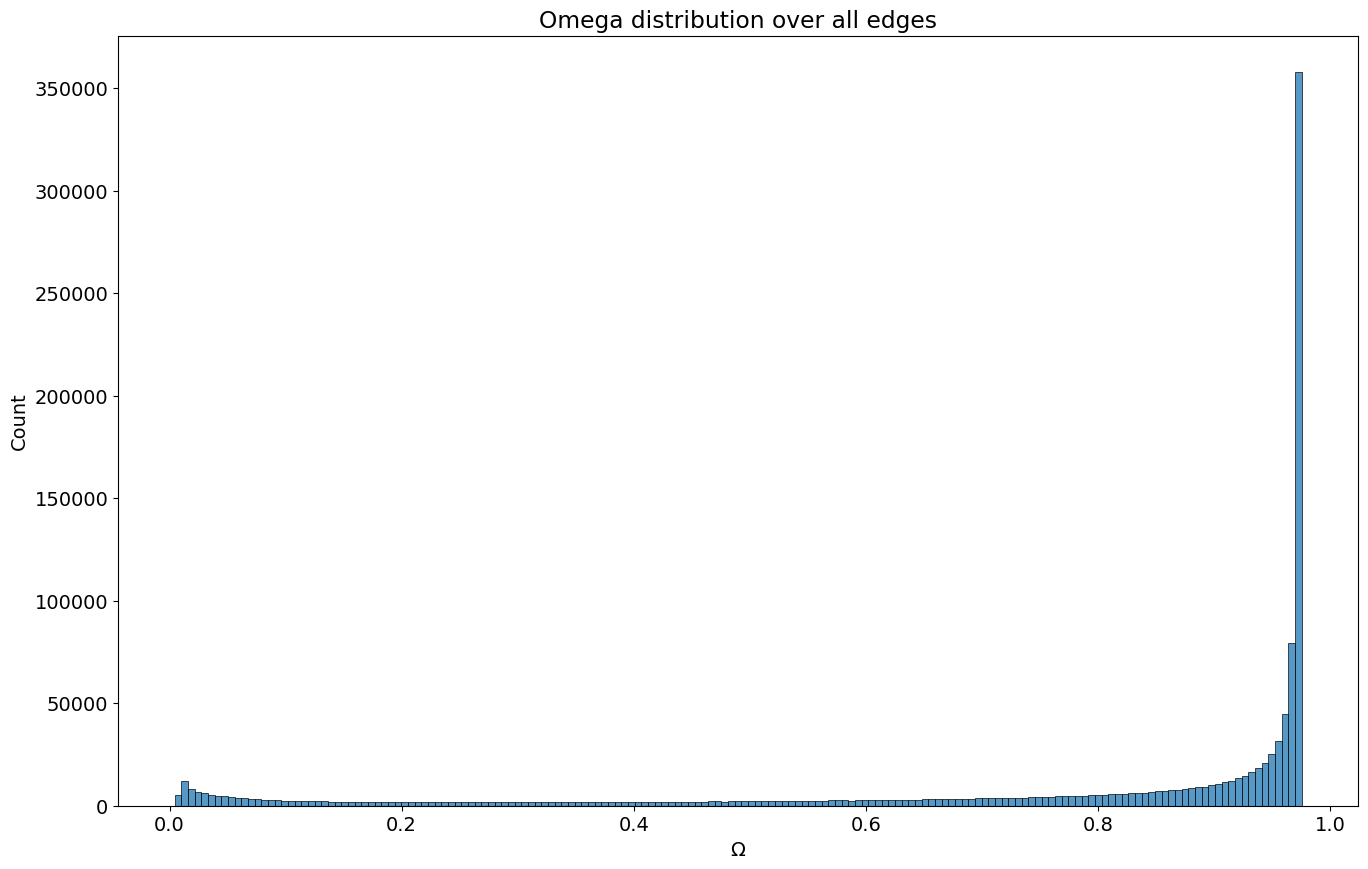

In [22]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_gamma_df['gamma_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
# plt.savefig('reports/images/best_omega_distribution.png')